In [65]:
import csv
import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

Data source:
- Bureau of Reclamation: Lake Mead, Lake Mohave, Lake Havasu
https://www.usbr.gov/uc/water/hydrodata/reservoir_data/920/csv/17.csv
- United States Geological Survey: San Carlos, , Bartlett Dam

- US Army Corps of Engineers (only go to previous 180 days): Alamo, Painted Rock 
- Salt River Project (only go to previous 1 year): Theodore Roosevelt, Horse Mesa Dam

In [66]:
LOWER_RESERVOIR_RECLAMATION = {921:['lake mead', 'AZ, NV'], 922: ['lake mohave', 'AZ, NV'], 923: ['lake havasu', 'AZ, CA']}
reclamation_url_head = 'https://www.usbr.gov/uc/water/hydrodata/reservoir_data/'
reclamation_url_tail = '/csv/17.csv'

In [67]:
def read_csv_from_url(url):
    response = requests.get(url)
    assert response.status_code == 200, 'Failed to download file'
    data = response.content.decode('utf-8')
    return pd.read_csv(StringIO(data))

In [68]:
columns = ['datetime', 'name', 'state', 'storage']
df = pd.DataFrame(columns=columns)

In [69]:
for reservoir_code, info in LOWER_RESERVOIR_RECLAMATION.items():
    data = read_csv_from_url(reclamation_url_head + str(reservoir_code) + reclamation_url_tail)
    data['name'] = info[0]
    data['state'] = info[1]
    data['datetime'] = pd.to_datetime(data['datetime'])
    data.set_index('datetime', inplace=True)
    data = data.groupby(['name', 'state'])['storage'].resample('M').mean().reset_index()
    data['datetime'] = data['datetime'].dt.to_period('M')
    df = pd.concat([df, data], ignore_index=True)

# convert unit from acre-feet to cubic kilometer
df['storage'] = df['storage'] * 0.000001233

In [70]:
df

,datetime,name,state,storage
0,1937-05,lake mead,"AZ, NV",12.550623
1,1937-06,lake mead,"AZ, NV",13.920422
2,1937-07,lake mead,"AZ, NV",15.119382
3,1937-08,lake mead,"AZ, NV",15.240785
4,1937-09,lake mead,"AZ, NV",14.948233
...,...,...,...,...
2930,2023-03,lake havasu,"AZ, CA",0.710195
2931,2023-04,lake havasu,"AZ, CA",0.708323
2932,2023-05,lake havasu,"AZ, CA",0.709725
2933,2023-06,lake havasu,"AZ, CA",0.710996


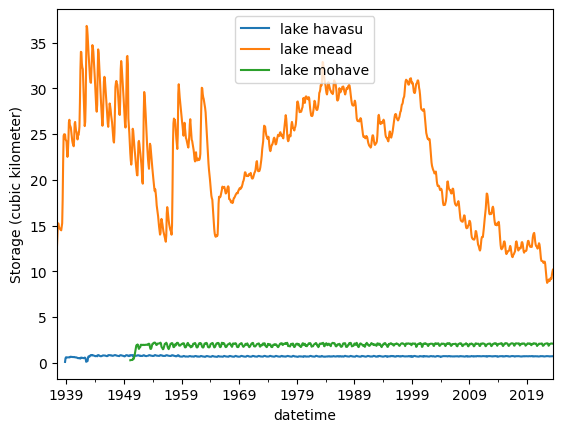

In [72]:
# Create a new figure
plt.figure()

# Iterate over the reservoir groups and plot each one
for name, group in df.groupby('name'):
    group.plot(x='datetime', y='storage', label=name, ax=plt.gca())

# Display the legend and show the plot
plt.legend()
plt.ylabel('Storage (cubic kilometer)')
plt.show()


In [74]:
reservoir_metadata = read_csv_from_url('https://www.usbr.gov/uc/water/hydrodata/reservoir_data/meta.csv') 

In [75]:
reservoir_metadata

,site_datatype_id,site_id,datatype_id,site_metadata.site_id,site_metadata.site_name,site_metadata.site_common_name,site_metadata.description,site_metadata.elevation,site_metadata.lat,site_metadata.longi,...,datatype_metadata.datatype_common_name,datatype_metadata.physical_quantity_name,datatype_metadata.unit_id,datatype_metadata.unit_name,datatype_metadata.unit_common_name,datatype_metadata.allowable_intervals,datatype_metadata.agen_id,datatype_metadata.cmmnt,last_meas_date,last_meas_val
0,24047,937,15,937,BRANTLEY LAKE,BRANTLEY,NaN,3249.0,32.5442,-104.3814,...,bank storage,bank storage,1,acre-feet,acre-feet,either,0,NaN,NaN,NaN
1,19744,2686,30,2686,HERON RESERVOIR,HERON,NaN,7157.0,36.6973,-106.6992,...,inflow volume,inflow,1,acre-feet,acre-feet,non-instant,0,NaN,NaN,NaN
2,100246,100003,17,100003,Marys Lake,MARYLACO,2016-01-11 Reconfigured with redundant PE sens...,NaN,40.3400,-105.5300,...,storage,storage,1,acre-feet,acre-feet,either,0,NaN,NaN,NaN
3,100251,100038,17,100038,Olympus Dam at Estes Park,OLYDAMCO,NaN,NaN,40.3800,-105.4900,...,storage,storage,1,acre-feet,acre-feet,either,0,NaN,NaN,NaN
4,100253,100113,17,100113,Pinewood Reservoir,PINRESCO,NaN,NaN,40.3700,-105.2900,...,storage,storage,1,acre-feet,acre-feet,either,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,101012,100163,17,100163,TURQUOISE LAKE AT SUGARLOAF DAM NEAR LEADVILLE CO,TURQLACO,FryArk Accounting,9747.0,39.2529,-106.3743,...,storage,storage,1,acre-feet,acre-feet,either,0,NaN,NaN,NaN
757,101013,100257,17,100257,"MOUNT ELBERT FOREBAY, CO",MTELFBCO,NaN,9650.0,39.0608,-106.2112,...,storage,storage,1,acre-feet,acre-feet,either,0,NaN,NaN,NaN
758,101014,100275,17,100275,"TWIN LAKES RESERVOIR, CO",TWIRESCO,"Twin Lakes Reservoir, meteorological data, and...",NaN,39.0767,-106.3029,...,storage,storage,1,acre-feet,acre-feet,either,0,NaN,NaN,NaN
759,101075,100275,49,100275,"TWIN LAKES RESERVOIR, CO",TWIRESCO,"Twin Lakes Reservoir, meteorological data, and...",NaN,39.0767,-106.3029,...,pool elevation,water surface elevation,4,feet,feet,either,0,NaN,NaN,NaN


In [84]:
columns = ['reservoir_name', 'lat', 'lon']
reservoir_location = pd.DataFrame(columns=columns)

In [86]:
reservoir_info = reservoir_metadata[(reservoir_metadata['datatype_id'] == 17) & \
    reservoir_metadata['site_metadata.site_name'].str.lower().isin([info[0] for info in LOWER_RESERVOIR_RECLAMATION.values()])]
reservoir_info = reservoir_info[['site_metadata.site_name', 'site_metadata.lat', 'site_metadata.longi']]
reservoir_info.rename(columns={'site_metadata.site_name':'name', 'site_metadata.lat':'lat', 'site_metadata.longi':'lon'})
reservoir_info = reservoir_info.reset_index(drop=True)

In [87]:
reservoir_info

,site_metadata.site_name,site_metadata.lat,site_metadata.longi
0,Lake Mead,36.0163,-114.7374
1,Lake Mohave,35.1979,-114.5694
2,Lake Havasu,34.2964,-114.1385


test